In [1]:
from docplex.mp.model import Model
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
def create_data(num_customers,num_facilities):
    np.random.seed(42)
    H = np.random.randint(1,10,num_customers) #demand
    I = np.random.randint(1,100,(num_customers,2)) #customer
    J = np.random.randint(1,100,(num_facilities,2)) #facility

    return H,I,J

In [3]:
def calculate_distance(num_customers,num_facilities,I,J):
    distances = np.zeros((num_customers,num_facilities))
    for i in range(num_customers):
        for j in range(num_facilities):
            distances[i,j] = np.linalg.norm(I[i]-J[j])
            
    return distances

In [4]:
def cplex_model_solve(num_customers,num_facilities,p):

    H,I,J = create_data(num_customers,num_facilities)
    distances = calculate_distance(num_customers,num_facilities,I,J)

    m = Model('PMP')

    # decision variable
    x = m.binary_var_list(num_facilities,name='x')
    y = m.binary_var_matrix(num_customers,num_facilities,name='y')

    # objective
    m.minimize(m.sum(H[i]*distances[i,j]*y[i,j] for i in range(num_customers) for j in range(num_facilities)))

    # constraint
    m.add_constraint(m.sum(x[j] for j in range(num_facilities))==p)
    m.add_constraints(y[i,j]<=x[j] for i in range(num_customers) for j in range(num_facilities))
    m.add_constraints(m.sum(y[i,j] for j in range(num_facilities))==1 for i in range(num_customers))

    print('< Modle info >')
    m.print_information()
    print()
    print('< Model report >')
    solution=m.solve()
    m.report()
    print()
    #print("objective = ",solution.get_objective_value())
    #print("best bound = ",m.solve_details.best_bound)
    #print("mip gap = ",m.solve_details.mip_relative_gap)

    return m,solution,I,J

In [5]:
def result_list(sol,num_facilities,num_customers):
    open_idx = []
    for i in range(num_facilities):
        if sol['x_{}'.format(i)] == 1.0:
            open_idx.append(i)
    
    mapping_f_c = []
    for i in open_idx:
        for j in range(num_customers):
            if sol['y_{}_{}'.format(j,i)] == 1.0:
                mapping_f_c.append([i,j])

    return open_idx, mapping_f_c

In [6]:
def results_visualization(sol,num_facilities,num_customers,p,I,J):
    open_idx, mapping_f_c = result_list(sol,num_facilities,num_customers)

    for i in open_idx:
        plt.scatter(J[i][0],J[i][1],color='r',label='facility')
        plt.text(J[i][0],J[i][1]+3,'F{}'.format(i))

    for i in mapping_f_c:
        facility_idx = i[0]
        customer_idx = i[1]
        color = plt.cm.tab10(facility_idx)
        plt.scatter(I[customer_idx][0], I[customer_idx][1], color=color)
        plt.text(I[customer_idx][0], I[customer_idx][1],'c{}'.format(customer_idx),alpha=0.5)

    for k in mapping_f_c:
        j,i = k
        plt.plot([J[j][0],I[i][0]],[J[j][1],I[i][1]],color='gray',alpha=0.2)

    # legend
    legend_elements = []
    added_colors = set()
    legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10,
                                  label='Facility'))
    for i in mapping_f_c:
        facility_idx = i[0]
        if facility_idx not in added_colors:
            color = plt.cm.tab10(facility_idx)
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10,
                                          label='Customers receiving service from F{}'.format(facility_idx)))
            added_colors.add(facility_idx)
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.0,1.0))
    
    plt.title("<P-median cplex> \n num_facilities:{}, num_customers:{}, p:{} \n objective: {}".format(num_facilities,num_customers,p,
                                                                                                  sol.objective_value))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid()
    plt.show()

In [7]:
num_facilities = 10
num_customers = 50
p = 3

In [8]:
m,solution,I,J = cplex_model_solve(num_customers,num_facilities,p)

< Modle info >
Model: PMP
 - number of variables: 510
   - binary=510, integer=0, continuous=0
 - number of constraints: 551
   - linear=551
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP

< Model report >
* model PMP solved with objective = 6969.747



In [9]:
m.solve_details

docplex.mp.SolveDetails(time=0.015,status='integer optimal solution')

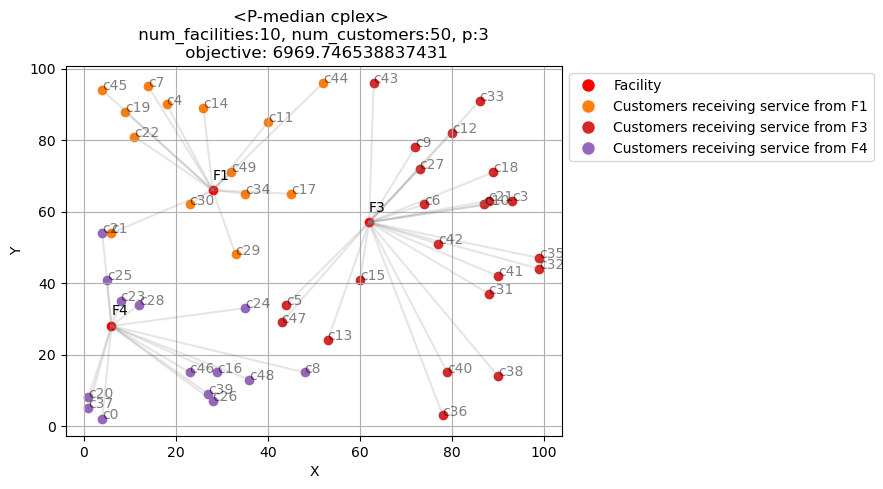

In [10]:
results_visualization(solution,num_facilities,num_customers,p,I,J)

In [19]:
def data_size(start_f,end_f,start_c,end_c,p):
    
    f_idx = []
    c_idx = [i for i in range(start_c, end_c, 100)]
    time_list = []
    objectval = []
    gap = []
    for i in range(end_f,start_f-1,-1):
        f_idx.append(i)
        temp1 = []
        temp2 = []
        temp3 = []
        for j in range(start_c,end_c,100):
            m,solution,I,J=cplex_model_solve(j,i,p)
            temp1.append(m.solve_details.time)
            if solution is None:
                temp2.append(-1)
                temp3.append(-1)
            else:
                temp2.append(m.solve_details.gap)
                temp3.append(solution.get_objective_value())
        time_list.append(temp1)
        gap.append(temp2)
        objectval.append(temp3)
    
    time_matrix = np.array(time_list)
    sns.heatmap(time_matrix, xticklabels=c_idx, yticklabels=f_idx, annot=True, fmt=".3f",cmap='YlGnBu',annot_kws={"size":8})
    plt.xlabel('num_customer')
    plt.ylabel('num_facility')
    plt.title('Heatmap of Time')
    plt.show()

    obj_matrix = np.array(objectval)
    sns.heatmap(obj_matrix, xticklabels=c_idx, yticklabels=f_idx, annot=True, fmt=".1f",cmap='YlGnBu',annot_kws={"size":6})
    plt.xlabel('num_customer')
    plt.ylabel('num_facility')
    plt.title('Heatmap of Objective')
    plt.show()

    gap_matrix = np.array(gap)
    sns.heatmap(gap_matrix, xticklabels=c_idx, yticklabels=f_idx, annot=True, fmt=".2f",annot_kws={"size":8})
    plt.xlabel('num_customer')
    plt.ylabel('num_facility')
    plt.title('Heatmap of Gap')
    plt.show()


< Modle info >
Model: PMP
 - number of variables: 1010
   - binary=1010, integer=0, continuous=0
 - number of constraints: 1101
   - linear=1101
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP

< Model report >
* model PMP solved with objective = 10838.684

< Modle info >
Model: PMP
 - number of variables: 2010
   - binary=2010, integer=0, continuous=0
 - number of constraints: 2201
   - linear=2201
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP

< Model report >
* model PMP solved with objective = 20017.379

< Modle info >
Model: PMP
 - number of variables: 3010
   - binary=3010, integer=0, continuous=0
 - number of constraints: 3301
   - linear=3301
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP

< Model report >
* model PMP solved with objective = 29495.570

< Modle info >
Model: PMP
 - number of variables: 4010
   - binary=4010, integer=0, continuous=0
 - number of constraints: 4401
   - linear=4401
 - parame

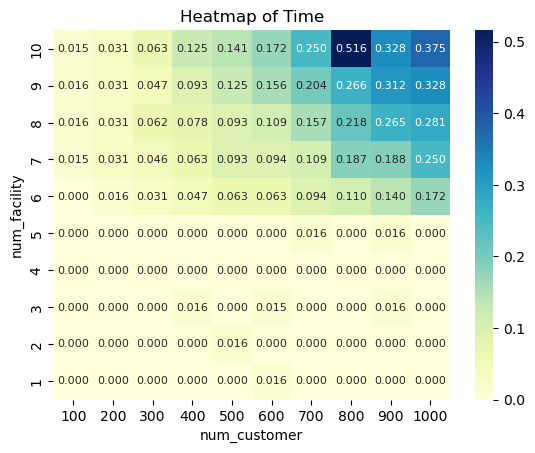

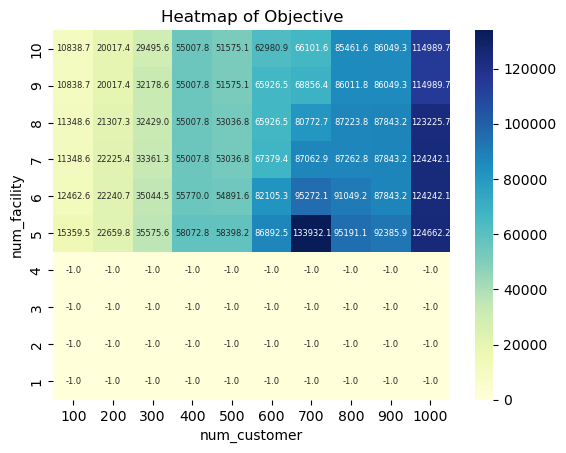

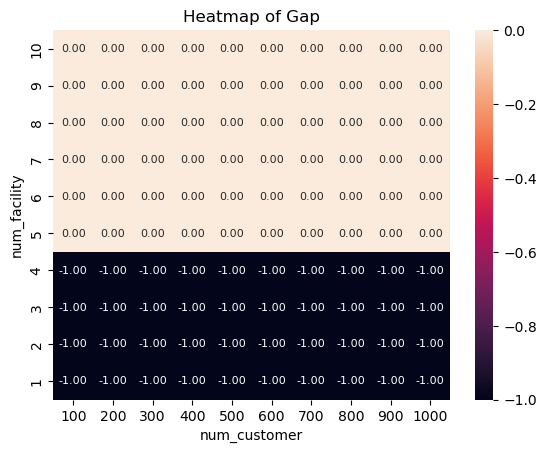

In [20]:
data_size(1,10,100,1001,5)